# Experiments for CS224U Project

## Setup

### Imports

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
import csv
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [2]:
import utils
import sst
import scipy.stats
from sgd_classifier import BasicSGDClassifier

In [3]:
from sklearn.linear_model import LogisticRegression
import os

In [4]:
import numpy as np

### Dataset

In [5]:
def read_array_from_csv(inputcsv):
    out = []
    with open(inputcsv, encoding='utf-8') as f:
        reader = csv.reader(f)
        for q in reader:
            out.append(q)
    return out

In [6]:
new_train = read_array_from_csv('data/train_data.csv')

In [7]:
anon_new_train = read_array_from_csv('data/anon_train_data.csv')

In [8]:
anon_new_test = read_array_from_csv('data/anon_test_data.csv')

### SST Machinery

In [9]:
def hansard_reader(
        src_filename,
        class_func=None):
    """Overview

    Parameters
    ----------
    src_filename : str
        Full path to the file to be read.
    class_func : None, or function mapping labels to labels or None
        If this is None, then the original 5-way labels are returned.
        Other options: `binary_class_func` and `ternary_class_func`
        (or you could write your own).


    Yields
    ------
    (tree, label)
        nltk.Tree, str in {'0','1','2','3','4'}

    """
    if class_func is None:
        class_func = lambda x: x
    with open(src_filename, encoding='utf-8') as f:
        reader = csv.reader(f)
        for q in reader:
            yield (q[0], class_func(q[1]))

We need a reader for each dataset, both for train and for test.

First, the standard data:

In [10]:
def train_reader(**kwargs):
    """Convenience function for reading the train file, full-trees only."""
    src = 'data/train_data.csv'
    return hansard_reader(src,**kwargs)

Next, the anonymised data:

In [11]:
def anon_train_reader(**kwargs):
    src = 'data/anon_train_data.csv'
    return hansard_reader(src,**kwargs)

The test readers won't be used until the *very* end.

In [12]:
def cas_to_gov(label):
    if label == 'cas':
        return 'gov'
    else:
        return label

In [13]:
train_data = [(question, label) for question, label in anon_train_reader(class_func=cas_to_gov)]
X, y = zip(*train_data)
X = list(X)
y = list(y)

## MLP Classifier

First, load up some stuff from sklearn

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neural_network import MLPClassifier
# from sklearn.preprocessing import StandardScaler

In [16]:
# scaler = StandardScaler(with_mean=False)

In [17]:
# Specify the vectorising function
uniVectorizer = CountVectorizer(ngram_range=(1,1))
biVectorizer = CountVectorizer(ngram_range=(1,2))

In [18]:
# Apply the vectorising function to the dataset
X_vec = uniVectorizer.fit_transform(X)
X_biVec = biVectorizer.fit_transform(X)

In [20]:
# Split the dataset so that we can make predictions
X_train, X_test, y_train, y_test = train_test_split(X_vec, y)

X_biTrain, X_biTest, y_biTrain, y_biTest = train_test_split(X_biVec, y)

In [21]:
# Scaling is recommended by sklearn, but doesn't seem to help in our case.
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

Now we're ready to set out classifier running

16,16,16,16 seems to work well, so it's possible to get slight improvements using the generality that neural nets offer. But it's not really _much_ better.

In [22]:
mlp = MLPClassifier(hidden_layer_sizes=(2),
                    activation='relu',
                    alpha=0.0001,
                    solver='sgd',
                    learning_rate='adaptive',
                    tol=1e-10,
#                     verbose=True,
                    max_iter=2000)

In [23]:
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=2, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=1e-10, validation_fraction=0.1,
       verbose=False, warm_start=False)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=2, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=1e-10, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [24]:
mlp.score(X_train,y_train)
predictions = mlp.predict(X_train)
print(classification_report(y_train,predictions))

             precision    recall  f1-score   support

        gov       0.96      0.97      0.96      2633
        opp       0.98      0.98      0.98      4990

avg / total       0.97      0.97      0.97      7623

             precision    recall  f1-score   support

        gov       0.96      0.97      0.96      2633
        opp       0.98      0.98      0.98      4990

avg / total       0.97      0.97      0.97      7623



In [25]:
# Make and print predictions
predictions = mlp.predict(X_test)
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

        gov       0.67      0.61      0.64       914
        opp       0.79      0.83      0.81      1628

avg / total       0.75      0.75      0.75      2542

             precision    recall  f1-score   support

        gov       0.67      0.61      0.64       914
        opp       0.79      0.83      0.81      1628

avg / total       0.75      0.75      0.75      2542



In [26]:
### Tf-idf

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
vectorizer = TfidfVectorizer(min_df=1)
X_idf = vectorizer.fit_transform(X)

In [29]:
X_idf_train, X_idf_test, y_idf_train, y_idf_test = train_test_split(X_vec, y)

In [30]:
# scaler.fit(X_idf_train)
# X_idf_train = scaler.transform(X_idf_train)
# X_idf_test = scaler.transform(X_idf_test)

In [31]:
mlp.fit(X_idf_train,y_idf_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=2, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=1e-10, validation_fraction=0.1,
       verbose=False, warm_start=False)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=2, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=1e-10, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [32]:
predictions = mlp.predict(X_idf_test)
print(classification_report(y_idf_test,predictions))

             precision    recall  f1-score   support

        gov       0.63      0.62      0.63       859
        opp       0.81      0.82      0.81      1683

avg / total       0.75      0.75      0.75      2542

             precision    recall  f1-score   support

        gov       0.63      0.62      0.63       859
        opp       0.81      0.82      0.81      1683

avg / total       0.75      0.75      0.75      2542



In [33]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn import datasets

# different learning rate schedules and momentum parameters
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}
         ]

labels = ["constant learning-rate", 
          "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", 
          "adam"
         ]

plot_args = [{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '--'},
             {'c': 'green', 'linestyle': '--'},
             {'c': 'blue', 'linestyle': '--'},
             {'c': 'black', 'linestyle': '-'}
            ]


def plot_on_dataset(X, y, ax, name):
    # for each dataset, plot learning for each learning strategy
    print("\nlearning on dataset %s" % name)
    ax.set_title(name)
    X = MaxAbsScaler().fit_transform(X)
    mlps = []
#     if name == "digits":
#         # digits is larger but converges fairly quickly
#         max_iter = 15
#     else:
#         max_iter = 400
    max_iter = 200

    for label, param in zip(labels, params):
        print("training: %s" % label)
        mlp = MLPClassifier(hidden_layer_sizes=(2),
#                             verbose=1, 
                            random_state=0,
                            max_iter=max_iter, 
                            **param)
        mlp.fit(X, y)
        mlps.append(mlp)
        print("Training set score: %f" % mlp.score(X, y))
        print("Training set loss: %f" % mlp.loss_)
    for mlp, label, args in zip(mlps, labels, plot_args):
            ax.plot(mlp.loss_curve_, label=label, **args)


fig, axes = plt.subplots(1, 2, figsize=(15, 10))
# load / generate some toy datasets
data_sets = [
    (X_train,y_train),
    (X_biTrain, y_biTrain),
             ]

for ax, data, name in zip(axes.ravel(), data_sets, ['unigrams', '(uni+bi)grams',
                                                    ]):
    plot_on_dataset(*data, ax=ax, name=name)

fig.legend(ax.get_lines(), labels, ncol=3, loc="upper center")
plt.show()


learning on dataset unigrams
training: constant learning-rate

learning on dataset unigrams
training: constant learning-rate
Training set score: 0.975469
Training set loss: 0.049528
training: constant with momentum
Training set score: 0.975469
Training set loss: 0.049528
training: constant with momentum
Training set score: 0.654598
Training set loss: 0.645307
training: constant with Nesterov's momentum
Training set score: 0.654598
Training set loss: 0.645307
training: constant with Nesterov's momentum
Training set score: 0.973895
Training set loss: 0.083429
training: inv-scaling learning-rate
Training set score: 0.973895
Training set loss: 0.083429
training: inv-scaling learning-rate
Training set score: 0.654598
Training set loss: 0.648483
training: inv-scaling with momentum
Training set score: 0.654598
Training set loss: 0.648483
training: inv-scaling with momentum
Training set score: 0.654598
Training set loss: 0.642120
training: inv-scaling with Nesterov's momentum
Training set sco

/Users/sparkes/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/sparkes/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set score: 0.923259
Training set loss: 0.240729
training: inv-scaling with Nesterov's momentum
Training set score: 0.923259
Training set loss: 0.240729
training: inv-scaling with Nesterov's momentum
Training set score: 0.908173
Training set loss: 0.272216
training: adam
Training set score: 0.908173
Training set loss: 0.272216
training: adam
Training set score: 0.991998
Training set loss: 0.023062
Training set score: 0.991998
Training set loss: 0.023062


<Figure size 1500x1000 with 2 Axes>

<Figure size 1500x1000 with 2 Axes>

In [34]:
plt.show()

## Doing the same for movie reviews

In [35]:
import re

movieList = []

movies = open('../additionalData/trees/train.txt','r')
for line in movies:
    score = int(line[1])
    if score == 3:
        pass
    else:
        if score > 3:
            score = 1
        else:
            score = -1
        line = re.sub('\(\d', '', line)
        line = re.sub('\)', '', line)
        line = re.sub("\s+", " ", line)
        line = re.sub("\s+'", "'", line)
        movieList.append([score, line])

In [ ]:
testMovieList = []

movies = open('../additionalData/trees/test.txt','r')
for line in movies:
    score = int(line[1])
    if score == 3:
        pass
    else:
        if score > 3:
            score = 1
        else:
            score = -1
        line = re.sub('\(\d', '', line)
        line = re.sub('\)', '', line)
        line = re.sub("\s+", " ", line)
        line = re.sub("\s+'", "'", line)
        testMovieList.append([score, line])

In [36]:
mX = [str(item[1]) for item in movieList]
my = [item[0] for item in movieList]

In [37]:
mX_vec = uniVectorizer.fit_transform(mX)
mX_biVec = biVectorizer.fit_transform(mX)


learning on dataset unigrams
training: constant learning-rate

learning on dataset unigrams
training: constant learning-rate
Training set score: 0.998714
Training set loss: 0.009553
training: constant with momentum
Training set score: 0.998714
Training set loss: 0.009553
training: constant with momentum
Training set score: 0.999839
Training set loss: 0.002679
training: constant with Nesterov's momentum
Training set score: 0.999839
Training set loss: 0.002679
training: constant with Nesterov's momentum
Training set score: 0.999839
Training set loss: 0.002522
training: inv-scaling learning-rate
Training set score: 0.999839
Training set loss: 0.002522
training: inv-scaling learning-rate
Training set score: 0.792993
Training set loss: 0.505709
training: inv-scaling with momentum
Training set score: 0.792993
Training set loss: 0.505709
training: inv-scaling with momentum


/Users/sparkes/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/sparkes/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set score: 0.792993
Training set loss: 0.456284
training: inv-scaling with Nesterov's momentum
Training set score: 0.792993
Training set loss: 0.456284
training: inv-scaling with Nesterov's momentum
Training set score: 0.792993
Training set loss: 0.499653
training: adam
Training set score: 0.792993
Training set loss: 0.499653
training: adam
Training set score: 0.999839
Training set loss: 0.001731

learning on dataset (uni+bi)grams
training: constant learning-rate
Training set score: 0.999839
Training set loss: 0.001731

learning on dataset (uni+bi)grams
training: constant learning-rate
Training set score: 1.000000
Training set loss: 0.005365
training: constant with momentum
Training set score: 1.000000
Training set loss: 0.005365
training: constant with momentum
Training set score: 1.000000
Training set loss: 0.001366
training: constant with Nesterov's momentum
Training set score: 1.000000
Training set loss: 0.001366
training: constant with Nesterov's momentum
Training set sco

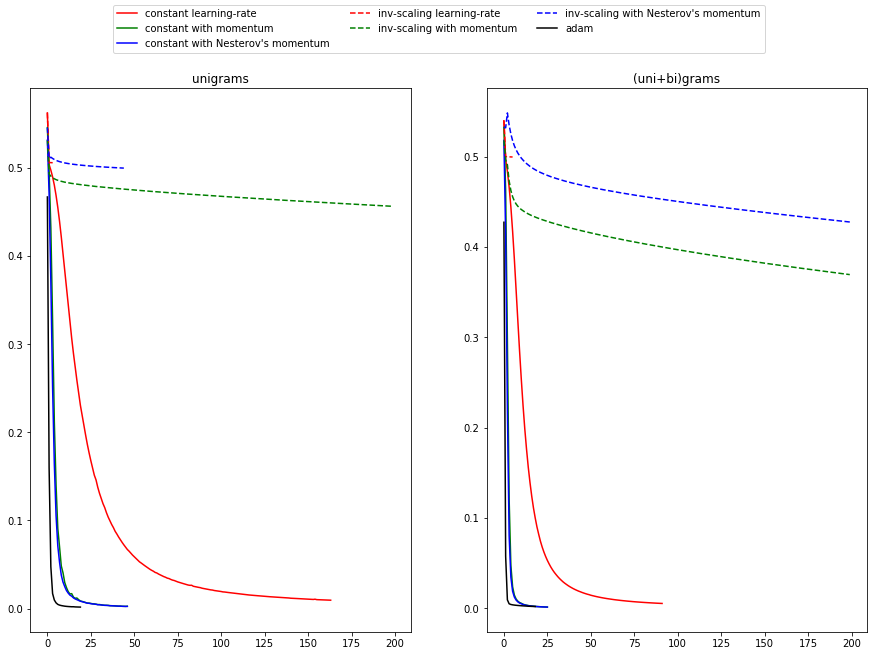

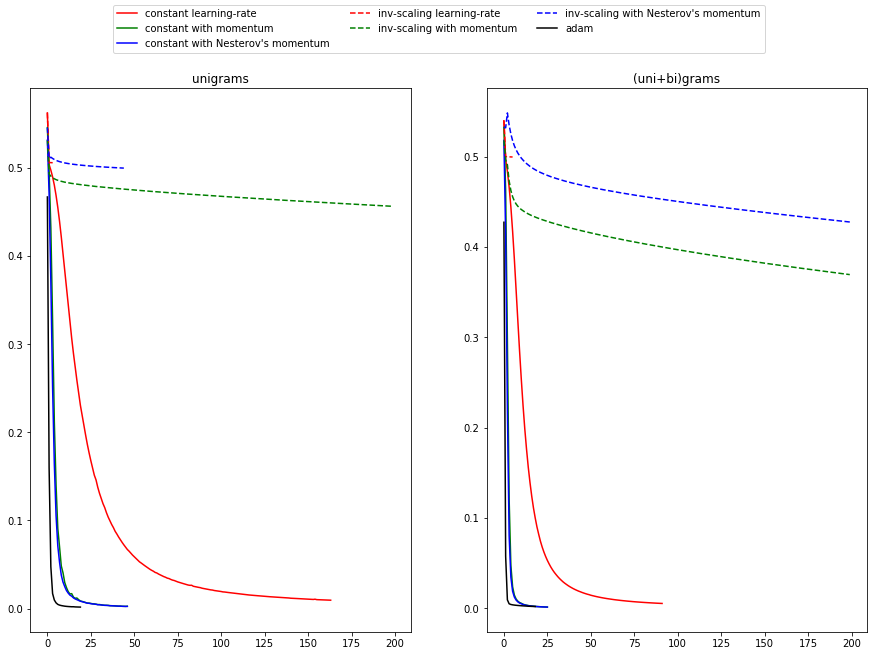

In [40]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn import datasets

# different learning rate schedules and momentum parameters
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}
         ]

labels = ["constant learning-rate", 
          "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", 
          "adam"
         ]

plot_args = [{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '--'},
             {'c': 'green', 'linestyle': '--'},
             {'c': 'blue', 'linestyle': '--'},
             {'c': 'black', 'linestyle': '-'}
            ]


def plot_on_dataset(X, y, ax, name):
    # for each dataset, plot learning for each learning strategy
    print("\nlearning on dataset %s" % name)
    ax.set_title(name)
    X = MaxAbsScaler().fit_transform(X)
    mlps = []
#     if name == "digits":
#         # digits is larger but converges fairly quickly
#         max_iter = 15
#     else:
#         max_iter = 400
    max_iter = 200

    for label, param in zip(labels, params):
        print("training: %s" % label)
        mlp = MLPClassifier(hidden_layer_sizes=(100),
#                             verbose=1, 
                            random_state=0,
                            max_iter=max_iter, 
                            **param)
        mlp.fit(X, y)
        mlps.append(mlp)
        print("Training set score: %f" % mlp.score(X, y))
        print("Training set loss: %f" % mlp.loss_)
    for mlp, label, args in zip(mlps, labels, plot_args):
            ax.plot(mlp.loss_curve_, label=label, **args)


fig, axes = plt.subplots(1, 2, figsize=(15, 10))
# load / generate some toy datasets
data_sets = [
    (mX_vec,my),
    (mX_biVec, my),
             ]

for ax, data, name in zip(axes.ravel(), data_sets, ['unigrams', '(uni+bi)grams',
                                                    ]):
    plot_on_dataset(*data, ax=ax, name=name)

fig.legend(ax.get_lines(), labels, ncol=3, loc="upper center")
plt.show()

## Comparing datasets

In [44]:
mlp = MLPClassifier(hidden_layer_sizes=(2),
                    activation='relu',
                    alpha=0.0001,
                    solver='adam',
                    learning_rate='adaptive',
                    tol=1e-10,
#                     verbose=True,
                    max_iter=2000)

In [45]:
mlp.fit(X_biTrain, y_biTrain)
mlp.score(X_biTrain, y_biTrain)
predictions = mlp.predict(mX_vec)
print(classification_report(my_vec,predictions))

ValueError: dimension mismatch

ValueError: dimension mismatch